# IF702 Redes Neurais
Este notebook contém um script base para o projeto da disciplina IF702 Redes Neurais.

In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

/home/romero/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Leitura e Limpeza dos Dados

A leitura dos dados é feita utilizando a biblioteca `pandas`. O presente exemplo importa a base de dados `mammography`. Caso você esteja trabalhando com outro data set, modifique este trecho de código.
Para importar o conjunto de dados do PAKDD, use a função `pd.read_table` ao invés da `pd.read_csv`.

In [2]:
data_set = pd.read_csv('data/mammography.csv.zip')
data_set.drop_duplicates(inplace=True)  # Remove exemplos repetidos

In [3]:
# Exibe as 5 primeiras linhas do data set
data_set.head(5)

,X1,X2,X3,X4,X5,X6,class
0,0.230020,5.072578,-0.276061,0.832444,-0.377866,0.480322,-1
1,0.155491,-0.169390,0.670652,-0.859553,-0.377866,-0.945723,-1
2,-0.784415,-0.443654,5.674705,-0.859553,-0.377866,-0.945723,-1
3,0.546088,0.131415,-0.456387,-0.859553,-0.377866,-0.945723,-1
4,-0.102987,-0.394994,-0.140816,0.979703,-0.377866,1.013566,-1


In [4]:
# Estatísticas sobre as variáveis
data_set.describe()

,X1,X2,X3,X4,X5,X6,class
count,7849.000000,7849.000000,7849.000000,7849.000000,7849.000000,7849.000000,7849.000000
mean,0.333194,0.199706,0.251306,0.365110,0.160505,0.401712,-0.935278
std,1.025862,1.136235,1.101344,0.988751,1.156892,0.939931,0.353935
min,-0.784415,-0.470195,-0.591631,-0.859553,-0.377866,-0.945723,-1.000000
25%,-0.145672,-0.408265,-0.276061,-0.859553,-0.377866,-0.945723,-1.000000
50%,0.111621,-0.271133,-0.005571,0.548898,-0.377866,0.845975,-1.000000
75%,0.508993,0.219887,0.400163,1.027382,0.386166,1.132403,-1.000000
max,31.508443,5.085849,29.477769,9.591164,23.617122,1.949027,1.000000


Agora vamos separar o data set em atributos dependentes (X = features) e independentes (y = classe). No caso do `mammography` a classe majoritária está codificada como -1 e a classe minoritária está codificada como 1. Para treinar nossa rede neural precisamos que os valores de classe sejam 0 e 1 (saída da última camada é uma sigmóide), assim modificamos a codificação da majoritária para 0.

Perceba que esse pré-processamento varia de data set para data set.

In [5]:
# Também convertemos os dados para arrays ao invés de DataFrames
X = data_set.iloc[:, :-1].values
y = data_set.iloc[:, -1].values
y = np.where(y == -1, 0, 1)

## Divisão dos Dados em Treino, Validação, e Teste

Aqui dividimos o data set em treino, validação e teste de maneira estratificada.

In [6]:
## Treino: 50%, Validação: 25%, Teste: 25%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/4, 
                                                    random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/3, 
                                                  random_state=42, stratify=y_train)

## Sampling dos Dados e Normalização

Para testar o comportamento da rede com diferentes funções de sampling, as mesmas devem ser implementadas e aplicadas ao conjunto de treinamento antes da normalização dos dados (você também pode investigar qual o efeito de aplicar o sampling após a normalização).

In [7]:
## TO DO -- Implementar as funções de sampling a serem utilizadas

É importante lembrar de normalizar os dados. A classe `StandardScaler` centraliza as variáveis e transforma as features para terem variância unitária. Você pode testar outras opções como o `MinMaxScaler`.

Todas as alternativas estão disponíveis em:
http://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing.

In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## Definição e Treino da Rede

Aqui definimos a arquitetura da nossa rede neural e treinamos ela.

No presente exemplo a rede possui apenas uma camada escondida. O código é bem intuitivo e a adição de novas camadas pode ser feita através da função `add`.

Para treinar a rede várias funções de otimização estão disponíveis. 

Confira os exemplos em: https://keras.io/optimizers/

O treinamento da rede pode ser interrompido baseado na performance dela em um conjunto de validação através de callbacks.

Confira a documentação da classe `EarlyStopping`: https://keras.io/callbacks/

In [9]:
# Número de features do nosso data set.
input_dim = X_train.shape[1]

# Aqui criamos o esboço da rede.
classifier = Sequential()

# Agora adicionamos a primeira camada escondida contendo 16 neurônios e função de ativação
# tangente hiperbólica. Por ser a primeira camada adicionada à rede, precisamos especificar
# a dimensão de entrada (número de features do data set).
classifier.add(Dense(16, activation='tanh', input_dim=input_dim))

# Em seguida adicionamos a camada de saída. Como nosso problema é binário só precisamos de
# 1 neurônio com função de ativação sigmoidal. A partir da segunda camada adicionada keras já
# consegue inferir o número de neurônios de entrada (16) e nós não precisamos mais especificar.
classifier.add(Dense(1, activation='sigmoid'))

# Por fim compilamos o modelo especificando um otimizador, a função de custo, e opcionalmente
# métricas para serem observadas durante treinamento.
classifier.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
# Para treinar a rede passamos o conjunto de treinamento e especificamos o tamanho do mini-batch,
# o número máximo de épocas, e opcionalmente callbacks. No seguinte exemplo utilizamos early
# stopping para interromper o treinamento caso a performance não melhore em um conjunto de validação.
history = classifier.fit(X_train, y_train, batch_size=64, epochs=100000, 
                         callbacks=[EarlyStopping(patience=3)], validation_data=(X_val, y_val))

Train on 3924 samples, validate on 1962 samples
Epoch 1/100000
3924/3924 [==============================] - 1s 369us/step - loss: 0.2219 - val_loss: 0.1736
Epoch 2/100000
3924/3924 [==============================] - 0s 38us/step - loss: 0.1418 - val_loss: 0.1149
Epoch 3/100000
3924/3924 [==============================] - 0s 38us/step - loss: 0.0925 - val_loss: 0.0745
Epoch 4/100000
3924/3924 [==============================] - 0s 37us/step - loss: 0.0603 - val_loss: 0.0506
Epoch 5/100000
3924/3924 [==============================] - 0s 36us/step - loss: 0.0423 - val_loss: 0.0378
Epoch 6/100000
3924/3924 [==============================] - 0s 32us/step - loss: 0.0327 - val_loss: 0.0310
Epoch 7/100000
3924/3924 [==============================] - 0s 37us/step - loss: 0.0274 - val_loss: 0.0271
Epoch 8/100000
3924/3924 [==============================] - 0s 36us/step - loss: 0.0242 - val_loss: 0.0248
Epoch 9/100000
3924/3924 [==============================] - 0s 39us/step - loss: 0.0222 - val_l

3924/3924 [==============================] - 0s 38us/step - loss: 0.0123 - val_loss: 0.0157
Epoch 77/100000
3924/3924 [==============================] - 0s 32us/step - loss: 0.0123 - val_loss: 0.0157


Algumas funções auxiliares.

In [11]:
def extract_final_losses(history):
    """Função para extrair o melhor loss de treino e validação.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    Dicionário contendo o melhor loss de treino e de validação baseado 
    no menor loss de validação.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history):
    """Função para plotar as curvas de erro do treinamento da rede neural.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    A função gera o gráfico do treino da rede e retorna None.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves', xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()

def compute_performance_metrics(y, y_pred_class, y_pred_scores=None):
    accuracy = accuracy_score(y, y_pred_class)
    recall = recall_score(y, y_pred_class)
    precision = precision_score(y, y_pred_class)
    f1 = f1_score(y, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    if y_pred_scores is not None:
        auroc = roc_auc_score(y, y_pred_scores)
        aupr = average_precision_score(y, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
    return performance_metrics

def print_metrics_summary(accuracy, recall, precision, f1, auroc=None, aupr=None):
    print()
    print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy))
    print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall))
    print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision))
    print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1))
    if auroc is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=auroc))
    if aupr is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUPR:", value=aupr))

<IPython.core.display.Javascript object>


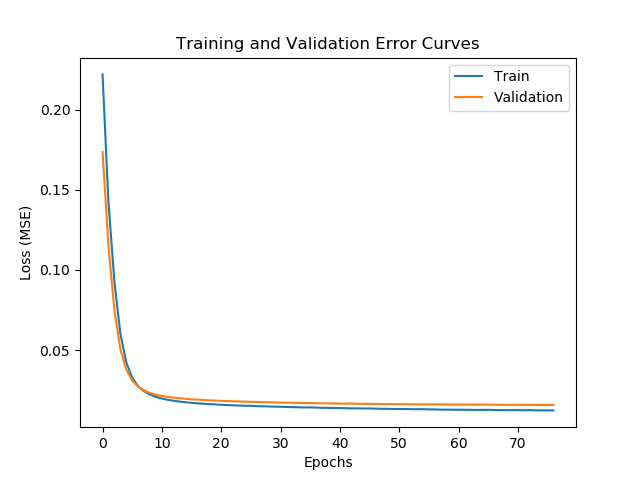

In [12]:
plot_training_error_curves(history)

## Predições no Conjunto de Teste

Agora utilizamos a nossa rede para fazer predições no conjunto de teste e computar métricas de desempenho.

Além das métricas utilizadas aqui, mais métricas de desempenho podem ser encontradas em: http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics

In [16]:
## Fazer predições no conjunto de teste
y_pred_scores = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão no conjunto de teste:')
print(confusion_matrix(y_test, y_pred_class))

## Resumo dos resultados
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print('\nPerformance no conjunto de teste:')
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, y_pred_class, y_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

Matriz de confusão no conjunto de teste:
[[1887   12]
 [  35   29]]

Train Loss:       0.0124
Validation Loss:  0.0157

Performance no conjunto de teste:

Accuracy:         0.9761
Recall:           0.4531
Precision:        0.7073
F1:               0.5524
AUROC:            0.9256
AUPR:             0.6252


# Comparando MLPs com outros classificadores

Agora iremos comparar a performance da nossa rede neural contra outros classificadores e por fim analisar a performance conjunta deles quando treinados em um ensemble.

In [17]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier

Função auxiliar para criar um classificador compatível com a API do pacote scikit-learn. Modifique a arquitetura da sua rede aqui.

In [18]:
def create_sklearn_compatible_model():
    model = Sequential()
    model.add(Dense(20, activation='tanh', input_dim=input_dim))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

Cria o classificador, treina, e avalia a performance no conjunto de validação. Apenas quando a melhor combinação de hyperparâmetros for escolhida o classificador deve ser avaliado no conjunto de teste.

In [19]:
mlp_clf = KerasClassifier(build_fn=create_sklearn_compatible_model, 
                          batch_size=64, epochs=100,
                          verbose=0)
mlp_clf.fit(X_train, y_train)
mlp_pred_class = mlp_clf.predict(X_val)
mlp_pred_scores = mlp_clf.predict_proba(X_val)[:, 1]
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, mlp_pred_class, mlp_pred_scores)
print('Performance no conjunto de validação:')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)


Accuracy:         0.9811
Recall:           0.5714
Precision:        0.7826
F1:               0.6606
AUROC:            0.9181
AUPR:             0.6918


In [21]:
svc_clf = SVC(probability=True)  # Modifique aqui os hyperparâmetros
svc_clf.fit(X_train, y_train)
svc_pred_class = svc_clf.predict(X_val)
svc_pred_scores = svc_clf.predict_proba(X_val)[:, 1]
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, svc_pred_class, svc_pred_scores)
print('Performance no conjunto de validação:')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

Performance no conjunto de validação:

Accuracy:         0.9781
Recall:           0.4444
Precision:        0.7778
F1:               0.5657
AUROC:            0.9042
AUPR:             0.6365


In [22]:
gb_clf = GradientBoostingClassifier()  # Modifique aqui os hyperparâmetros
gb_clf.fit(X_train, y_train)
gb_pred_class = gb_clf.predict(X_val)
gb_pred_scores = gb_clf.predict_proba(X_val)[:, 1]
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, gb_pred_class, gb_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)


Accuracy:         0.9817
Recall:           0.5556
Precision:        0.8140
F1:               0.6604
AUROC:            0.9490
AUPR:             0.6243


In [23]:
rf_clf = RandomForestClassifier()  # Modifique aqui os hyperparâmetros
rf_clf.fit(X_train, y_train)
rf_pred_class = rf_clf.predict(X_val)
rf_pred_scores = rf_clf.predict_proba(X_val)[:, 1]
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, rf_pred_class, rf_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)


Accuracy:         0.9776
Recall:           0.4603
Precision:        0.7436
F1:               0.5686
AUROC:            0.8745
AUPR:             0.5966


In [24]:
mlp_ens_clf = KerasClassifier(build_fn=create_sklearn_compatible_model,
                              batch_size=64, epochs=50, verbose=0)
svc_ens_clf = SVC(probability=True)
gb_ens_clf = GradientBoostingClassifier()
rf_ens_clf = RandomForestClassifier()
ens_clf = VotingClassifier([('mlp', mlp_ens_clf), ('svm', svc_ens_clf), ('gb', gb_ens_clf), ('rf', rf_ens_clf)], 
                           voting='soft')

ens_clf.fit(X_train, y_train)
ens_pred_class = ens_clf.predict(X_val)
ens_pred_scores = ens_clf.predict_proba(X_val)[:, 1]
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, ens_pred_class, ens_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)


Accuracy:         0.9822
Recall:           0.5556
Precision:        0.8333
F1:               0.6667
AUROC:            0.9396
AUPR:             0.6936


/home/romero/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Agora vamos analisar a performance final de todos os classificadores treinados e de nosso ensemble no conjunto de teste.

In [25]:
mlp_pred_class = mlp_clf.predict(X_test)
mlp_pred_scores = mlp_clf.predict_proba(X_test)[:, 1]
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, mlp_pred_class, mlp_pred_scores)
print('MLP')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

svc_pred_class = svc_clf.predict(X_test)
svc_pred_scores = svc_clf.predict_proba(X_test)[:, 1]
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, svc_pred_class, svc_pred_scores)
print('\n\nSupport Vector Machine')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

gb_pred_class = gb_clf.predict(X_test)
gb_pred_scores = gb_clf.predict_proba(X_test)[:, 1]
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, gb_pred_class, gb_pred_scores)
print('\n\nGradient Boosting')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

rf_pred_class = rf_clf.predict(X_test)
rf_pred_scores = rf_clf.predict_proba(X_test)[:, 1]
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, rf_pred_class, rf_pred_scores)
print('\n\nRandom Forest')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

ens_pred_class = ens_clf.predict(X_test)
ens_pred_scores = ens_clf.predict_proba(X_test)[:, 1]
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, ens_pred_class, ens_pred_scores)
print('\n\nEnsemble')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

MLP

Accuracy:         0.9766
Recall:           0.4531
Precision:        0.7250
F1:               0.5577
AUROC:            0.9265
AUPR:             0.6393


Support Vector Machine

Accuracy:         0.9745
Recall:           0.3594
Precision:        0.7188
F1:               0.4792
AUROC:            0.8764
AUPR:             0.5439


Gradient Boosting

Accuracy:         0.9755
Recall:           0.4375
Precision:        0.7000
F1:               0.5385
AUROC:            0.9167
AUPR:             0.5687


Random Forest

Accuracy:         0.9776
Recall:           0.4062
Precision:        0.8125
F1:               0.5417
AUROC:            0.8625
AUPR:             0.4945


Ensemble

Accuracy:         0.9755
Recall:           0.4062
Precision:        0.7222
F1:               0.5200
AUROC:            0.9344
AUPR:             0.6105


/home/romero/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Baseado no código acima você pode facilmente criar um ensemble de MLPs ou de outros classificadores.